## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML Helpers/Metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# Algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

# trees
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# fun ones
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Reusable Function for ML Experimentation

5-fold cross validation + train/test splits to generate images

Target metrics to minimize are cross validation RMSE + MAE

In [2]:
# Helper Function
def doMLRegression(model, X_train, y_train, X_test, y_test):
    # Set up k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validate the model
    cv_r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    cv_mse = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_mse)
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

    # Print cross-validation metrics
    print("CROSS-VALIDATION METRICS (Training Data)")
    print(f"Mean R2: {np.mean(cv_r2)}")
    print(f"Mean MSE: {np.mean(-cv_mse)}")
    print(f"Mean RMSE: {np.mean(cv_rmse)}")
    print(f"Mean MAE: {np.mean(-cv_mae)}")
    print()
    
    # fit the model
    model.fit(X_train, y_train)

    # predict the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # get the TRAIN metrics
    resids = y_train - train_preds
    r2 = r2_score(y_train, train_preds)
    mse = mean_squared_error(y_train, train_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, train_preds)

    # Print releveant metrics.
    print("TRAINING SET METRICS")
    print(f"The r2 is {r2}.")
    print(f"The mean squared error is {mse}.")
    print(f"The root mean squared error is {rmse}.")
    print(f"The mean absolute error is {mae}.")
    
    # get the TEST metrics
    resids = y_test - test_preds
    r2 = r2_score(y_test, test_preds)
    mse = mean_squared_error(y_test, test_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, test_preds)

    # Print releveant metrics.
    print()
    print("TESTING SET METRICS")
    print(f"The r2 is {r2}.")
    print(f"The mean squared error is {mse}.")
    print(f"The root mean squared error is {rmse}.")
    print(f"The mean absolute error is {mae}.")

    # make a graph

    # Predicted vs Actual Graph
    plt.scatter(test_preds, y_test)
    plt.xlabel("Predictions")
    plt.ylabel("Observed")
    plt.title("Predicted vs Actual Plot")
    plt.plot(y_test, y_test)
    plt.show()

    # Residual Graph
    plt.scatter(test_preds, resids)
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title("Residuals Plot")
    plt.plot(test_preds, np.zeros(len(test_preds)))
    plt.show()

## Load data

In [3]:
df = pd.read_csv("output/data/ml_soccer_data.csv")
print(df.shape)
df.head()

(3419, 58)


,season_name,player_id,player_name,minutes_played,offensive_goals_added,offensive_goals_added_90,player_age,guaranteed_compensation_1,minutes_played_1,share_team_touches_1,attempted_passes_1,completed_passes_1,total_distance_yds_1,total_vertical_distance_yds_1,xcompleted_passes_1,goals_added_above_avg_Dribbling_1,goals_added_above_avg_Fouling_1,goals_added_above_avg_Interrupting_1,goals_added_above_avg_Passing_1,goals_added_above_avg_Receiving_1,goals_added_above_avg_Shooting_1,guaranteed_compensation_2,minutes_played_2,share_team_touches_2,attempted_passes_2,completed_passes_2,total_distance_yds_2,total_vertical_distance_yds_2,xcompleted_passes_2,goals_added_above_avg_Dribbling_2,goals_added_above_avg_Fouling_2,goals_added_above_avg_Interrupting_2,goals_added_above_avg_Passing_2,goals_added_above_avg_Receiving_2,goals_added_above_avg_Shooting_2,guaranteed_compensation_3,minutes_played_3,share_team_touches_3,attempted_passes_3,completed_passes_3,total_distance_yds_3,total_vertical_distance_yds_3,xcompleted_passes_3,goals_added_above_avg_Dribbling_3,goals_added_above_avg_Fouling_3,goals_added_above_avg_Interrupting_3,goals_added_above_avg_Passing_3,goals_added_above_avg_Receiving_3,goals_added_above_avg_Shooting_3,played_two_years_ago,played_three_years_ago,primary_position_AM,primary_position_CB,primary_position_CM,primary_position_DM,primary_position_FB,primary_position_ST,primary_position_W
0,2014,0Oq60APM6D,Jason Hernandez,1868.0,-1.202600,-0.057941,30.0,208333.0,1817.0,0.064367,513.0,412.0,12260.3289,5384.6294,422.5266,0.1371,0.15161,-1.1739,-0.5978,-0.4063,-0.2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,False
1,2014,0Oq60VgM6D,Jeff Larentowicz,3211.0,0.071294,0.001998,30.0,231000.0,3024.0,0.092425,1217.0,928.0,24863.7753,8774.1994,962.7394,-0.4790,0.26440,-1.1032,0.0300,0.3525,0.1768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,False,False,False
2,2014,0Oq67EgQ6D,Matt Besler,2415.0,1.094000,0.040770,26.0,180000.0,2811.0,0.113450,1605.0,1242.0,44430.6794,20073.7718,1242.5560,0.1821,0.25460,-1.8372,1.9678,-0.3481,-0.2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,False
3,2014,0Oq67k7Q6D,Tristan Bowen,69.0,-0.016700,-0.021783,22.0,156364.0,1259.0,0.053732,380.0,236.0,6457.6914,728.7155,270.9217,-0.4333,-0.16740,0.2524,0.0546,-0.9820,-0.3422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,True,False
4,2014,0Oq67xxQ6D,Brandon Barklage,970.0,0.263000,0.024402,27.0,71428.5,2011.0,0.079036,1063.0,795.0,22768.3239,10058.4741,808.8326,-0.4377,-0.05840,0.6478,0.6542,-0.1870,-0.0851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,False


In [4]:
df.season_name.value_counts()

season_name
2022    492
2021    465
2020    419
2019    389
2018    357
2016    334
2014    328
2017    321
2015    314
Name: count, dtype: int64

# Predict offensive_goals_added_90

In [5]:
# Create our train/test set
target_cols = ['season_name', 'player_id', 'player_name', 'minutes_played', 'offensive_goals_added', 'offensive_goals_added_90']

X = df.drop(columns=target_cols)
y = df["offensive_goals_added_90"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.25,
                                                    random_state=42,)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2564, 52) (2564,)
(855, 52) (855,)


### Model Experimentation

Linear models will use a StandardScaler to normalize the input features

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.07313440633103323
Mean MSE: 0.007777328335775746
Mean RMSE: 0.08713971615953837
Mean MAE: 0.05023025747559886

TRAINING SET METRICS
The r2 is 0.1081601834331527.
The mean squared error is 0.007489561535611907.
The root mean squared error is 0.0865422528919366.
The mean absolute error is 0.048968834011344047.

TESTING SET METRICS
The r2 is 0.07944705696413512.
The mean squared error is 0.0094340859658229.
The root mean squared error is 0.09712922302697011.
The mean absolute error is 0.045612664840484124.


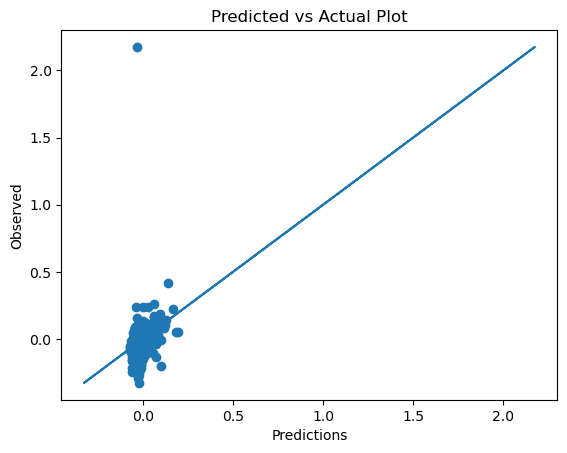

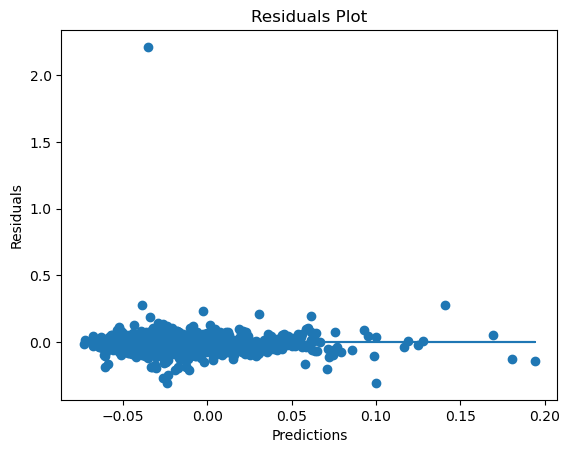

In [6]:
lr = Pipeline([
    ('scaler', StandardScaler()), 
    ('lr', LinearRegression())
])
doMLRegression(lr, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.07454711611489787
Mean MSE: 0.007766641893006734
Mean RMSE: 0.08707610169206295
Mean MAE: 0.050144813983755435

TRAINING SET METRICS
The r2 is 0.1080376221400714.
The mean squared error is 0.007490590790338333.
The root mean squared error is 0.0865481992322101.
The mean absolute error is 0.04895269749318091.

TESTING SET METRICS
The r2 is 0.07986732416536824.
The mean squared error is 0.009429778949116209.
The root mean squared error is 0.0971070489157003.
The mean absolute error is 0.045600785670363714.


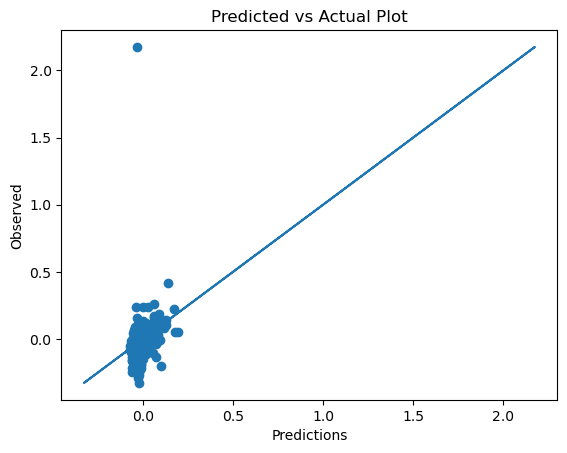

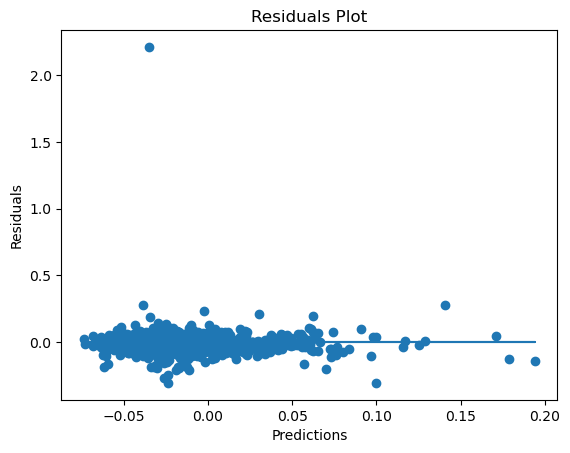

In [7]:
ridge = Pipeline([
    ('scaler', StandardScaler()), 
    ('ridge', Ridge())
])
doMLRegression(ridge, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.006641012474496044
Mean MSE: 0.008416753349083372
Mean RMSE: 0.09074799587758753
Mean MAE: 0.05520476645707136

TRAINING SET METRICS
The r2 is 0.0.
The mean squared error is 0.008397877507244633.
The root mean squared error is 0.09163993402029834.
The mean absolute error is 0.05510285979357682.

TESTING SET METRICS
The r2 is -0.0007702419991468812.
The mean squared error is 0.010256175450290752.
The root mean squared error is 0.1012727774394025.
The mean absolute error is 0.051386169713976894.


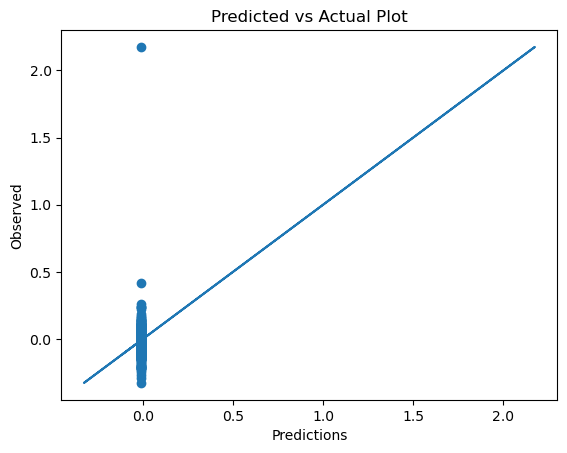

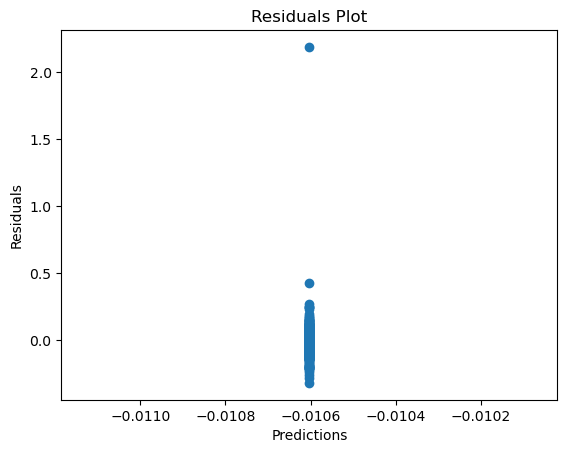

In [8]:
en = Pipeline([
    ('scaler', StandardScaler()), 
    ('en', ElasticNet())
])
doMLRegression(en, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.03177235352885157
Mean MSE: 0.008588987325348294
Mean RMSE: 0.09177157619832707
Mean MAE: 0.056262064246874154

TRAINING SET METRICS
The r2 is 0.1100419262625052.
The mean squared error is 0.007473758889830869.
The root mean squared error is 0.08645090450556818.
The mean absolute error is 0.052680821905879575.

TESTING SET METRICS
The r2 is -0.03391645327676507.
The mean squared error is 0.01059586716384187.
The root mean squared error is 0.10293622862647471.
The mean absolute error is 0.05187708502937159.


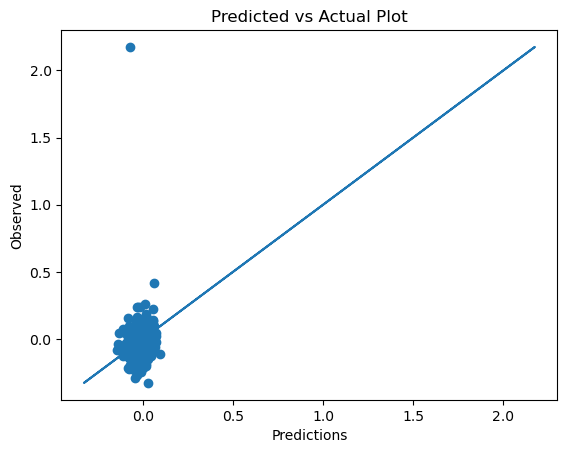

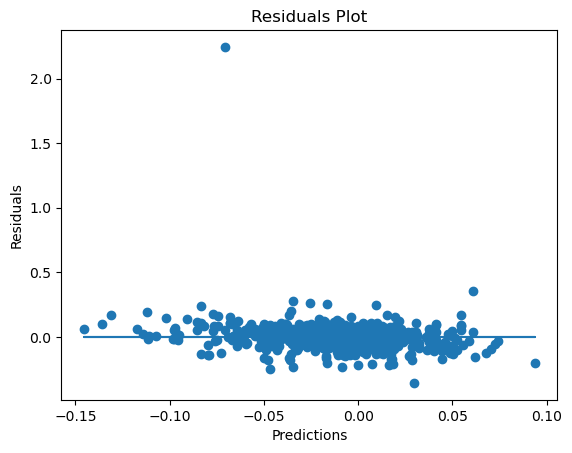

In [9]:
knn = KNeighborsRegressor(n_neighbors=15)
doMLRegression(knn, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.026262702484721866
Mean MSE: 0.00810871663032258
Mean RMSE: 0.089132517232181
Mean MAE: 0.05173209180564139

TRAINING SET METRICS
The r2 is 0.8655789699188288.
The mean squared error is 0.0011288513450193227.
The root mean squared error is 0.03359838307150097.
The mean absolute error is 0.019193606391497798.

TESTING SET METRICS
The r2 is 0.09436274177215531.
The mean squared error is 0.009281225824771243.
The root mean squared error is 0.09633911887063969.
The mean absolute error is 0.04672728263210143.


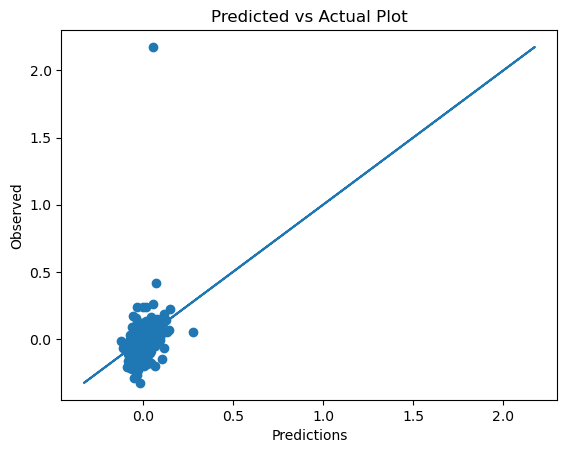

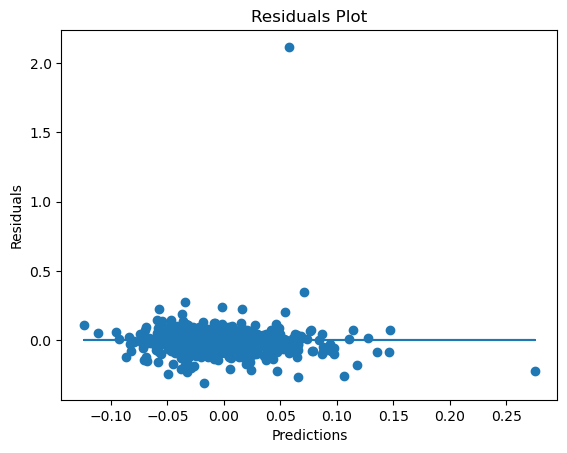

In [10]:
rf = RandomForestRegressor(random_state=42)
doMLRegression(rf, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.2208202007277465
Mean MSE: 0.009848814262209538
Mean RMSE: 0.0988547097734559
Mean MAE: 0.06325559421986432

TRAINING SET METRICS
The r2 is -0.008184329675580804.
The mean squared error is 0.008466608505339068.
The root mean squared error is 0.09201417556734977.
The mean absolute error is 0.06595237421139186.

TESTING SET METRICS
The r2 is -0.24793814910819778.
The mean squared error is 0.012789221812588318.
The root mean squared error is 0.11308944164946752.
The mean absolute error is 0.06523379517185877.


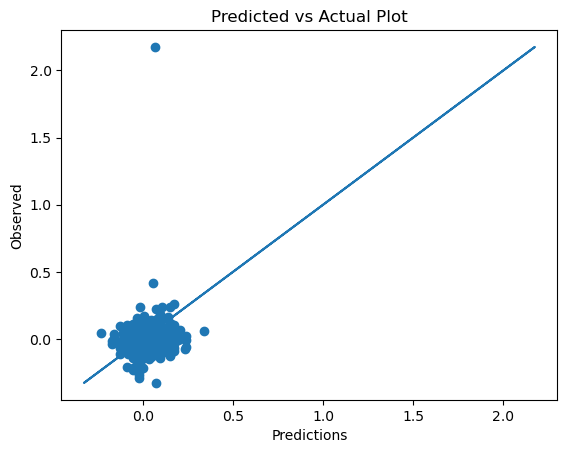

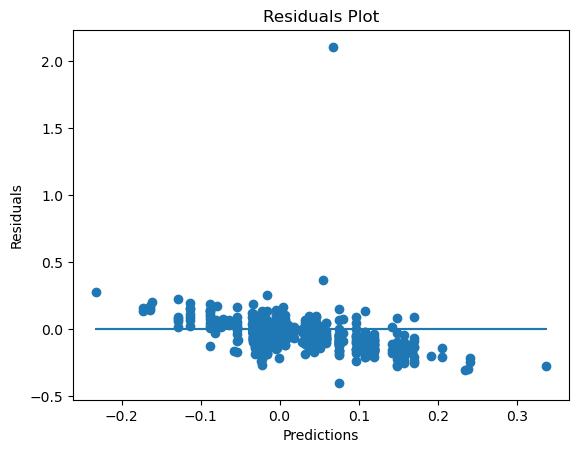

In [11]:
ada = AdaBoostRegressor(random_state=42)
doMLRegression(ada, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.18944454328641513
Mean MSE: 0.009902140719418504
Mean RMSE: 0.09849980116823107
Mean MAE: 0.0577164291182769

TRAINING SET METRICS
The r2 is 0.9776429606749453.
The mean squared error is 0.0001877516776764611.
The root mean squared error is 0.013702250825191498.
The mean absolute error is 0.009456565521684173.

TESTING SET METRICS
The r2 is 0.09827610385041186.
The mean squared error is 0.009241120587434312.
The root mean squared error is 0.09613074735709856.
The mean absolute error is 0.050929693503653214.


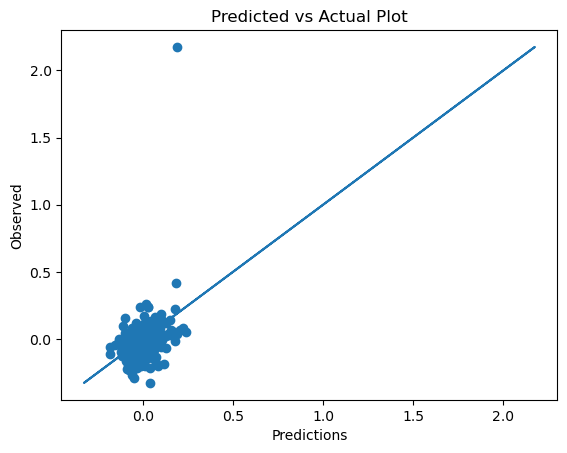

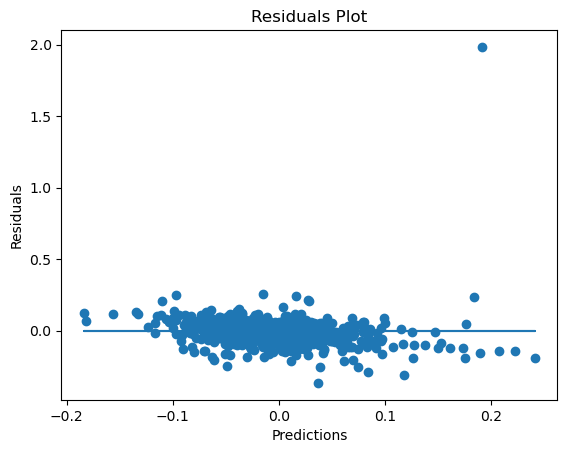

In [12]:
xgb = XGBRegressor(random_state=42)
doMLRegression(xgb, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.03832434986691093
Mean MSE: 0.008621454642553804
Mean RMSE: 0.0919980456021876
Mean MAE: 0.054621159395275766

TRAINING SET METRICS
The r2 is 0.7279954635143956.
The mean squared error is 0.0022842607788209597.
The root mean squared error is 0.04779394081702156.
The mean absolute error is 0.02767551658333114.

TESTING SET METRICS
The r2 is 0.012005376259920264.
The mean squared error is 0.01012524731428904.
The root mean squared error is 0.10062428789456868.
The mean absolute error is 0.04965402375008201.


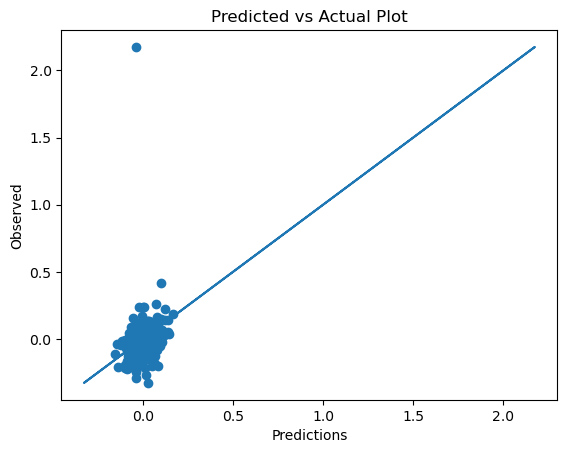

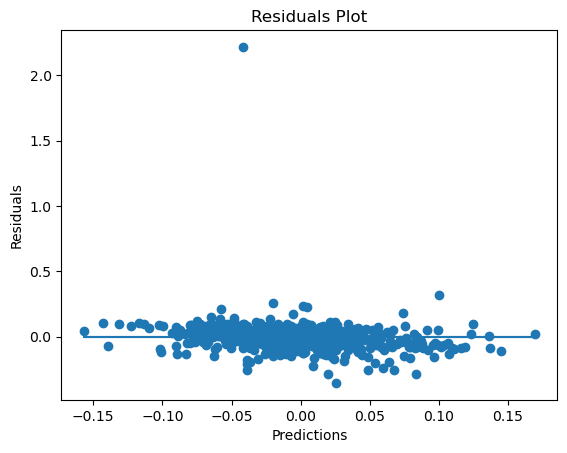

In [13]:
lgb = LGBMRegressor(random_state=42, verbosity=-1)
doMLRegression(lgb, X_train, y_train, X_test, y_test)

In [14]:
fi = pd.DataFrame(list(zip(X.columns, lgb.feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False).head(20)

,Feature,Importance
3,share_team_touches_1,224
2,minutes_played_1,194
13,goals_added_above_avg_Receiving_1,176
9,goals_added_above_avg_Dribbling_1,170
1,guaranteed_compensation_1,164
7,total_vertical_distance_yds_1,163
6,total_distance_yds_1,161
4,attempted_passes_1,158
10,goals_added_above_avg_Fouling_1,142
12,goals_added_above_avg_Passing_1,137


## Results

Ridge model performs the best in MAE/RMSE.

Tree and boosted models do not perform as well as the linear models.

Feature importances seem to make sense - data from most recent year is most important, as well as passing statistics. Salary is an important feature

# Model Selection

In [15]:
import pickle

# Initialize and train the model on the entire dataset
model = Pipeline([
    ('scaler', StandardScaler()), 
    ('ridge', Ridge())
])
model.fit(X, y)

# Get absolute coefficients
coef_abs = np.abs(model["ridge"].coef_)

# Normalize the coefficients (optional)
coef_normalized = coef_abs / np.sum(coef_abs)
fi = pd.DataFrame(list(zip(X.columns, coef_normalized)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False).head(20)

,Feature,Importance
5,completed_passes_1,0.109578
8,xcompleted_passes_1,0.081392
36,xcompleted_passes_3,0.076956
4,attempted_passes_1,0.068119
32,attempted_passes_3,0.059245
33,completed_passes_3,0.049707
3,share_team_touches_1,0.036591
12,goals_added_above_avg_Passing_1,0.032581
13,goals_added_above_avg_Receiving_1,0.031697
1,guaranteed_compensation_1,0.029852


In [16]:
# Save the model to a file
with open('models/final/oga90_model.pkl', 'wb') as file:
    pickle.dump(model, file)